In [1]:
import pandas as pd

# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/order_add2.csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71717 entries, 0 to 71716
Columns: 153 entries, StudyID to Glucose_iqr_to_std_pre_1_2.5h
dtypes: bool(1), float64(109), int64(23), object(20)
memory usage: 83.2+ MB


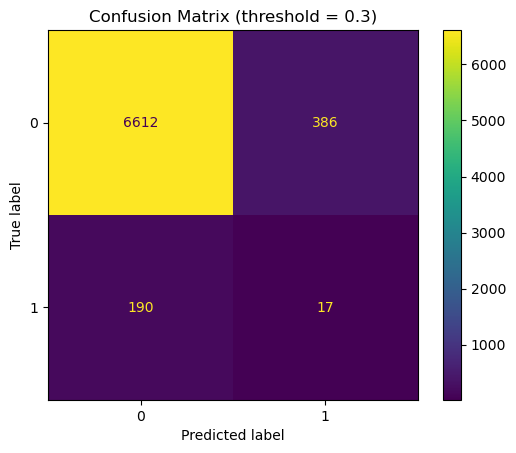

📋 Classification Report:

              precision    recall  f1-score   support

           0     0.9721    0.9448    0.9583      6998
           1     0.0422    0.0821    0.0557       207

    accuracy                         0.9201      7205
   macro avg     0.5071    0.5135    0.5070      7205
weighted avg     0.9454    0.9201    0.9323      7205

📈 Evaluation Metrics:
Accuracy:  0.9201
Precision: 0.0422
Recall:    0.0821
F1 Score:  0.0557
ROC AUC:   0.6104
PR AUC:    0.0392

🔍 Feature Importance (Top 15):
              Feature  Importance
47     1.5_2h_pre_std    0.055183
44     1_1.5h_pre_std    0.048802
50     2_2.5h_pre_std    0.045250
13    hungry_weighted    0.044616
15  mean_intensity_1h    0.041354
16  mean_intensity_2h    0.034257
3        15m_G_Diff_8    0.033642
12           Time_24h    0.032560
48   1.5_2h_pre_slope    0.029363
29         Sleep_Diff    0.029187
17  mean_intensity_3h    0.026767
5       15m_G_Diff_10    0.025227
1        15m_G_Diff_6    0.025129
51   2_2.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/order_add2.csv'
# 
df = pd.read_csv(file_path, encoding="utf-8")

# Convert Time_24h to float hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4"
    
]

# Remove rows with missing values
df_model = df[X_columns + ["Onset_GE", "StudyID"]].dropna()
df_model = df_model[~df_model["StudyID"].isin([8, 40, 59, 86])]

X = df_model[X_columns]
y = df_model["Onset_GE"].astype(int)

# Split train/test
X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# SMOTE with dynamic k_neighbors
minority_class_size = np.bincount(y_train_raw)[1]
k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

# Predict
y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred_thresh = (y_proba >= threshold).astype(int)

# Evaluation
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh)
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred_thresh, digits=4))
print("📈 Evaluation Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_thresh):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR AUC:    {average_precision_score(y_test, y_proba):.4f}")

# Feature importance
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n🔍 Feature Importance (Top 15):")
print(importances.head(15))


In [5]:
# Count label occurrences in train set
print("📊 y_train class distribution:")
print(y_train.value_counts())

# Count label occurrences in test set
print("\n📊 y_test class distribution:")
print(y_test.value_counts())


📊 y_train class distribution:
Onset_GE
0    27991
1    27991
Name: count, dtype: int64

📊 y_test class distribution:
Onset_GE
0    6998
1     207
Name: count, dtype: int64


# RandomizedSearchCV

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
      'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2', None],                      # Number of features to consider at every split
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],        # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10, 15, 20],                             # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4, 6, 8],                                 # Minimum number of samples required at each leaf node
    'bootstrap': [True, False],                                          # Method of selecting samples for training each tree
    'criterion': ['gini', 'entropy'],                                    # Function to measure the quality of a split
    'class_weight': [None, 'balanced', 'balanced_subsample']             # Weights associated with classes
}
 

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=50, scoring='recall', cv=2, verbose=10, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Best parameter combination
print("🔍 Best Hyperparameters:")
print(random_search.best_params_)


# Best model directly
best_model = random_search.best_estimator_

# Evaluate the best model
from sklearn.metrics import classification_report, f1_score

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\n📋 Classification Report (Best Model):")
print(classification_report(y_test, y_pred, digits=4))

print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")


Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV 2/2; 1/50] START bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=900
[CV 2/2; 1/50] END bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=900;, score=0.697 total time=16.0min
[CV 2/2; 20/50] START bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=900
[CV 2/2; 20/50] END bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=900;, score=0.994 total time= 3.0min


/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File 

[CV 1/2; 2/50] START bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_depth=None, max_features=None, min_samples_leaf=6, min_samples_split=15, n_estimators=300
[CV 1/2; 2/50] END bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_depth=None, max_features=None, min_samples_leaf=6, min_samples_split=15, n_estimators=300;, score=0.921 total time= 8.3min
[CV 1/2; 10/50] START bootstrap=True, class_weight=None, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400
[CV 1/2; 10/50] END bootstrap=True, class_weight=None, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=nan total time=   0.0s
[CV 2/2; 10/50] START bootstrap=True, class_weight=None, criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400
[CV 2/2; 10/50] END bootstrap=True, class_weight=None, criterion=ent

In [13]:
import pandas as pd

# RandomizedSearchCV 결과를 DataFrame으로 변환
results = pd.DataFrame(random_search.cv_results_)

# recall 
top5 = results.sort_values(by='mean_test_score', ascending=False).head(5)

# top5 recall 
top5[['mean_test_score', 'params']]


,mean_test_score,params
18,0.978171,"{'n_estimators': 600, 'min_samples_split': 2, ..."
38,0.978099,"{'n_estimators': 400, 'min_samples_split': 5, ..."
22,0.978064,"{'n_estimators': 400, 'min_samples_split': 10,..."
44,0.977850,"{'n_estimators': 600, 'min_samples_split': 2, ..."
21,0.977528,"{'n_estimators': 800, 'min_samples_split': 15,..."


In [19]:
# Top1 모델의 인덱스 (여기선 18번이라고 하셨죠)
top1_index = 18

# Top1 모델의 하이퍼파라미터 출력
top1_params = results.loc[top1_index, "params"]
print("🔍 Top1 모델 하이퍼파라미터:")
for key, value in top1_params.items():
    print(f"{key}: {value}")


🔍 Top1 모델 하이퍼파라미터:
n_estimators: 600
min_samples_split: 2
min_samples_leaf: 2
max_features: sqrt
max_depth: 90
criterion: entropy
class_weight: None
bootstrap: False


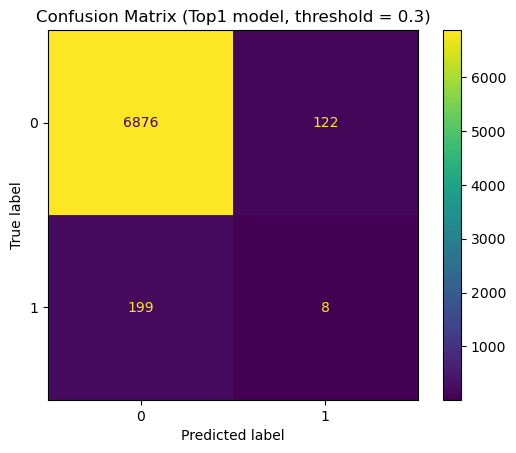

📋 Classification Report:
              precision    recall  f1-score   support

           0     0.9719    0.9826    0.9772      6998
           1     0.0615    0.0386    0.0475       207

    accuracy                         0.9554      7205
   macro avg     0.5167    0.5106    0.5123      7205
weighted avg     0.9457    0.9554    0.9505      7205

📈 Evaluation Metrics:
Accuracy:  0.9554
Precision: 0.0615
Recall:    0.0386
F1 Score:  0.0475
ROC AUC:   0.6082
PR AUC:    0.0398


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import pandas as pd

# Top1 하이퍼파라미터 (index = 18)
top1_params = {
    'n_estimators': 600,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': 90,
    'criterion': 'entropy',
    'class_weight': 'balanced',
    'bootstrap': False
}

# 모델 학습
model_top1 = RandomForestClassifier(**top1_params, random_state=42, n_jobs=-1)
model_top1.fit(X_train, y_train)

# 확률 예측
y_proba_top1 = model_top1.predict_proba(X_test)[:, 1]

# threshold = 0.3 적용
threshold = 0.3
y_pred_thresh_top1 = (y_proba_top1 >= threshold).astype(int)

# 혼동 행렬 시각화
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh_top1)
plt.title(f"Confusion Matrix (Top1 model, threshold = {threshold})")
plt.show()

# 평가 지표 출력
print("📋 Classification Report:")
print(classification_report(y_test, y_pred_thresh_top1, digits=4))

print("📈 Evaluation Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_thresh_top1):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_thresh_top1, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_thresh_top1, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_thresh_top1, zero_division=0):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba_top1):.4f}")
print(f"PR AUC:    {average_precision_score(y_test, y_proba_top1):.4f}")


In [23]:
# 🔍 Feature Importance (상위 15개)
importances_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model_top1.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n🔍 Top 15 Feature Importances:")
print(importances_df.head(15))


🔍 Top 15 Feature Importances:
              Feature  Importance
44     1_1.5h_pre_std    0.054865
47     1.5_2h_pre_std    0.053517
50     2_2.5h_pre_std    0.051741
13    hungry_weighted    0.043034
15  mean_intensity_1h    0.039759
45   1_1.5h_pre_slope    0.032364
3        15m_G_Diff_8    0.031846
48   1.5_2h_pre_slope    0.031335
1        15m_G_Diff_6    0.031206
12           Time_24h    0.030896
29         Sleep_Diff    0.030113
51   2_2.5h_pre_slope    0.029158
5       15m_G_Diff_10    0.028559
16  mean_intensity_2h    0.028474
14         EMA_T_Diff    0.027001


# backward_elimination

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, average_precision_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 데이터 불러오기
df = pd.read_csv("/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/order_add2.csv")

# 시간 변환
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

# 피처 목록
X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4"
    
]
# 결측 및 제외 대상 제거
df_model = df[X_columns + ["Onset_GE", "StudyID"]].dropna()
df_model = df_model[~df_model["StudyID"].isin([8, 40, 59, 86])]

X = df_model[X_columns]
y = df_model["Onset_GE"].astype(int)

# backward feature elimination
X_current = X.copy()
features = X_columns.copy()
performance_log = []

while len(features) > 1:
    # Train/Test split
    X_train_raw, X_test, y_train_raw, y_test = train_test_split(X_current, y, stratify=y, test_size=0.2, random_state=42)
    
    # SMOTE
    minority = np.bincount(y_train_raw)[1]
    k_neighbors = min(5, minority - 1) if minority > 1 else 1
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

    # 모델 학습
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
    model.fit(X_train, y_train)

    # 예측 및 평가
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.3).astype(int)
    recall = recall_score(y_test, y_pred, zero_division=0)
    pr_auc = average_precision_score(y_test, y_proba)

    # 기록
    performance_log.append({
        "n_features": len(features),
        "removed_feature": None,
        "recall": recall,
        "pr_auc": pr_auc,
        "features": features.copy()
    })

    # 가장 덜 중요한 feature 제거
    importances = model.feature_importances_
    min_idx = np.argmin(importances)
    removed_feature = features.pop(min_idx)
    X_current = X_current[features]
    performance_log[-1]["removed_feature"] = removed_feature

# 결과 저장
results_df = pd.DataFrame(performance_log)



NameError: name 'results_df' is not defined

# 46pcs remodel

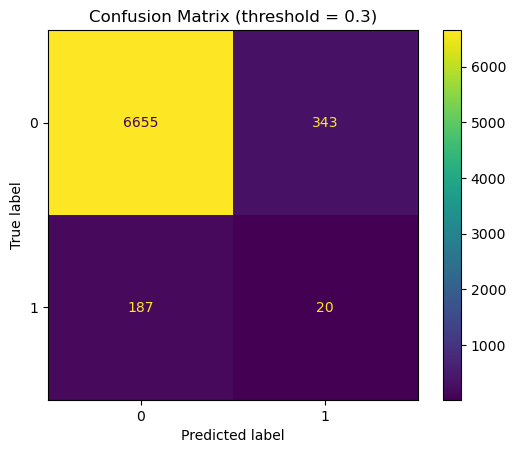

📋 Classification Report:

              precision    recall  f1-score   support

           0     0.9727    0.9510    0.9617      6998
           1     0.0551    0.0966    0.0702       207

    accuracy                         0.9264      7205
   macro avg     0.5139    0.5238    0.5159      7205
weighted avg     0.9463    0.9264    0.9361      7205

📈 Evaluation Metrics:
Accuracy:  0.9264
Precision: 0.0551
Recall:    0.0966
F1 Score:  0.0702
ROC AUC:   0.6004
PR AUC:    0.0411

🔍 Feature Importance (Top 15):
              Feature  Importance
39     1.5_2h_pre_std    0.054607
36     1_1.5h_pre_std    0.053509
42     2_2.5h_pre_std    0.053095
15  mean_intensity_1h    0.045436
13    hungry_weighted    0.043586
12           Time_24h    0.036316
37   1_1.5h_pre_slope    0.032165
16  mean_intensity_2h    0.031303
1        15m_G_Diff_6    0.031030
40   1.5_2h_pre_slope    0.030088
3        15m_G_Diff_8    0.029616
29         Sleep_Diff    0.028972
43   2_2.5h_pre_slope    0.026645
5       1

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/order_add2.csv'
# 
df = pd.read_csv(file_path, encoding="utf-8")

# Convert Time_24h to float hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

X_columns =['15m_G_Diff_5', '15m_G_Diff_6', '15m_G_Diff_7', '15m_G_Diff_8', '15m_G_Diff_9', '15m_G_Diff_10', 
            'Z_Previous_5', 'Z_Previous_6', 'Z_Previous_7', 'Z_Previous_8', 'Z_Previous_9', 'Z_Previous_10', 
            'Time_24h', 'hungry_weighted', 'EMA_T_Diff', 'mean_intensity_1h', 'mean_intensity_2h', 'mean_intensity_3h', 
            'HR_mean_1h', 'HR_mean_2h', 'HR_mean_3h', 'HR_std_1h', 'HR_std_2h', 'HR_std_3h', 'HR_slope_1h', 'HR_slope_2h', 
            'HR_slope_3h', 'TimeInBed', 'Efficiency', 'Sleep_Diff', 'Glucose_range_pre_1_2.5h', 'Glucose_spread_ratio_pre_1_2.5h',
            'Glucose_skew_hint_pre_1_2.5h', 'Glucose_std_pre_1_2.5h', 'Glucose_iqr_to_std_pre_1_2.5h', '1_1.5h_pre_mean', 
            '1_1.5h_pre_std', '1_1.5h_pre_slope', '1.5_2h_pre_mean', '1.5_2h_pre_std', '1.5_2h_pre_slope', '2_2.5h_pre_mean',
            '2_2.5h_pre_std', '2_2.5h_pre_slope', 'Glucose_q25_pre_1_2.5h', 'Z_Previous_4'
]
# Remove rows with missing values
df_model = df[X_columns + ["Onset_GE", "StudyID"]].dropna()
df_model = df_model[~df_model["StudyID"].isin([8, 40, 59, 86])]

X = df_model[X_columns]
y = df_model["Onset_GE"].astype(int)

# Split train/test
X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# SMOTE with dynamic k_neighbors
minority_class_size = np.bincount(y_train_raw)[1]
k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

# SMOTE 이후 column 복원
X_train = pd.DataFrame(X_train, columns=X_train_raw.columns)


# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

# Predict
y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred_thresh = (y_proba >= threshold).astype(int)

# Evaluation
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh)
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred_thresh, digits=4))
print("📈 Evaluation Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_thresh):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR AUC:    {average_precision_score(y_test, y_proba):.4f}")

# Feature importance
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n🔍 Feature Importance (Top 15):")
print(importances.head(15))

🔍 Best Threshold for F1: 0.2010 (F1 Score = 0.0870)


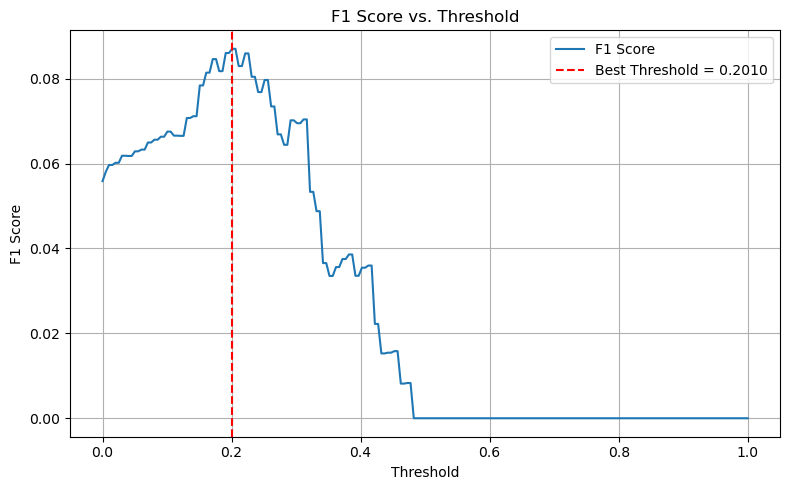

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


# 다양한 threshold에서 f1 score 계산
thresholds = np.linspace(0, 1, 200)
f1_scores = [f1_score(y_test, (y_proba >= t).astype(int), zero_division=0) for t in thresholds]

# 최적 threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# 출력
print(f"🔍 Best Threshold for F1: {best_threshold:.4f} (F1 Score = {best_f1:.4f})")

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.axvline(best_threshold, color="r", linestyle="--", label=f"Best Threshold = {best_threshold:.4f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


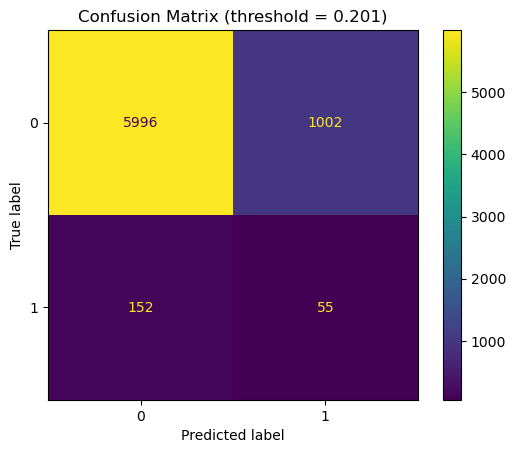

              precision    recall  f1-score   support

           0     0.9753    0.8568    0.9122      6998
           1     0.0520    0.2657    0.0870       207

    accuracy                         0.8398      7205
   macro avg     0.5137    0.5613    0.4996      7205
weighted avg     0.9488    0.8398    0.8885      7205



In [23]:
y_pred_best = (y_proba >= 0.201).astype(int)

# 새 threshold 적용 후 평가
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best)
plt.title("Confusion Matrix (threshold = 0.201)")
plt.show()

print(classification_report(y_test, y_pred_best, digits=4))


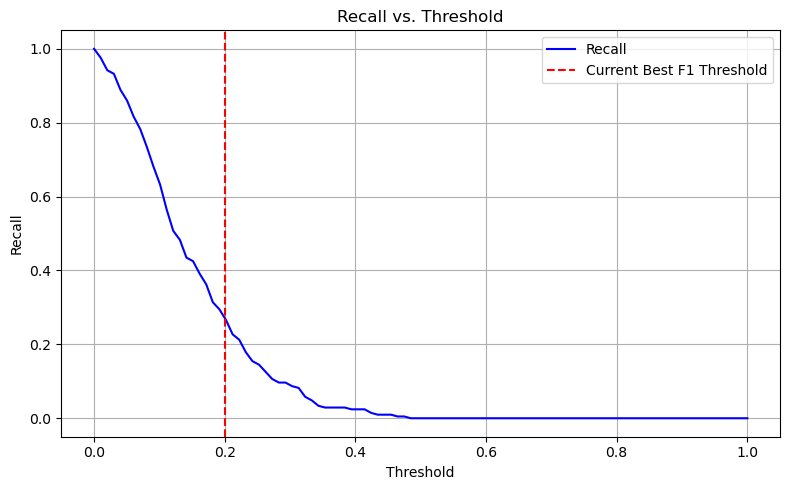

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# Thresholds 후보 생성
thresholds = np.linspace(0, 1, 100)
recalls = []

# threshold별 recall 계산
for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    recalls.append(recall_score(y_test, y_pred_thresh))

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls, label='Recall', color='blue')
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.title("Recall vs. Threshold")
plt.grid(True)
plt.axvline(x=0.201, color='red', linestyle='--', label='Current Best F1 Threshold')
plt.legend()
plt.tight_layout()
plt.show()


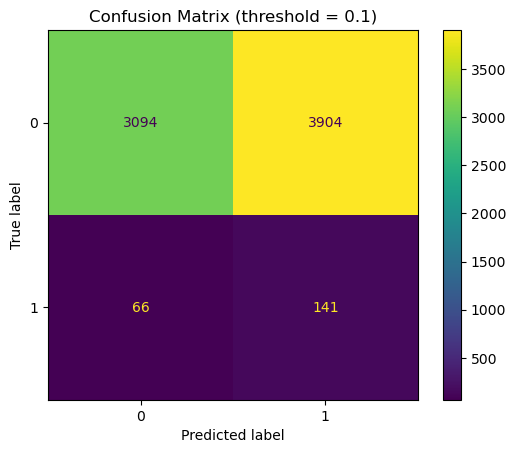

              precision    recall  f1-score   support

           0     0.9791    0.4421    0.6092      6998
           1     0.0349    0.6812    0.0663       207

    accuracy                         0.4490      7205
   macro avg     0.5070    0.5616    0.3377      7205
weighted avg     0.9520    0.4490    0.5936      7205



In [27]:
y_pred_best = (y_proba >= 0.1).astype(int)

# 새 threshold 적용 후 평가
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best)
plt.title("Confusion Matrix (threshold = 0.1)")
plt.show()

print(classification_report(y_test, y_pred_best, digits=4))


# SHAP (waterfall)

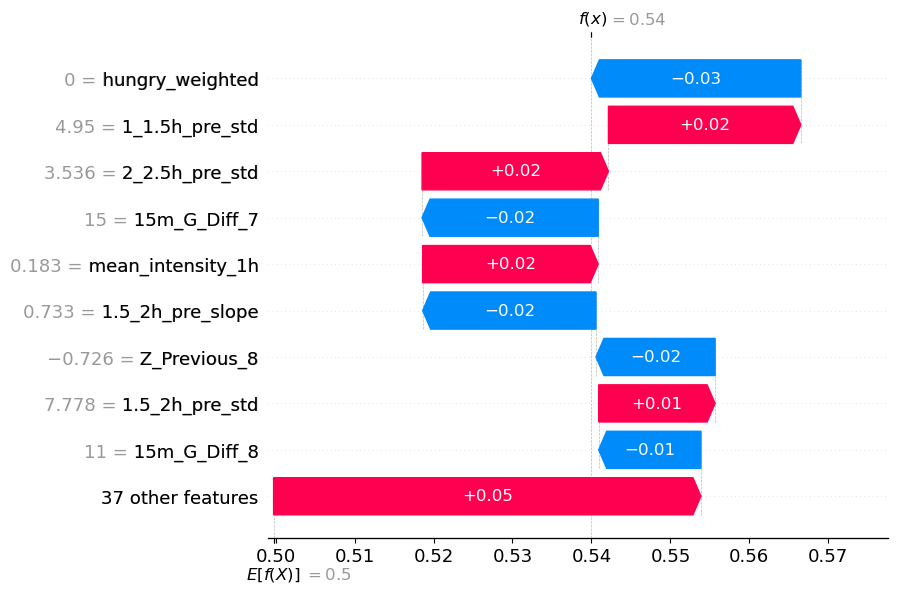

In [41]:
import shap

# SHAP explainer
explainer = shap.TreeExplainer(model)

# 확률 0.5 넘는 인덱스 추출
high_prob_indices = np.where(y_proba > 0.5)[0]

if len(high_prob_indices) == 0:
    print("❌ No samples found with predicted probability > 0.5.")
else:
    idx = high_prob_indices[6]  # 또는 다른 index 선택
    x_row = X_test.iloc[[idx]]

    # SHAP 값 계산
    shap_values = explainer.shap_values(x_row)

    # Waterfall plot for class 1
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[1][0],
            base_values=explainer.expected_value[1],
            data=x_row.values[0],
            feature_names=x_row.columns.tolist()
        )
    )



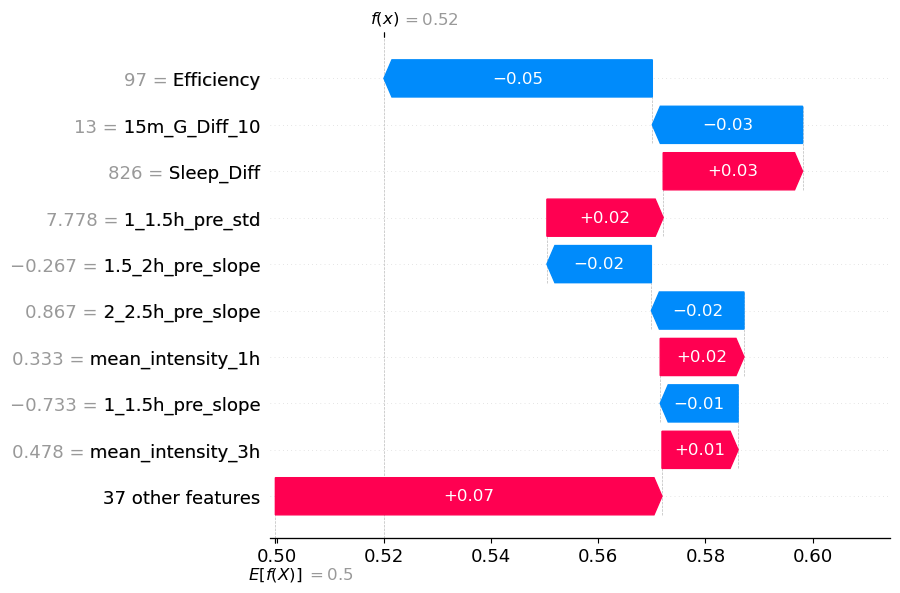

In [55]:
import shap

# SHAP explainer
explainer = shap.TreeExplainer(model)

# 확률 0.5 넘는 인덱스 추출
high_prob_indices = np.where(y_proba > 0.5)[0]

if len(high_prob_indices) == 0:
    print("❌ No samples found with predicted probability > 0.5.")
else:
    idx = high_prob_indices[12]  # 또는 다른 index 선택
    x_row = X_test.iloc[[idx]]

    # SHAP 값 계산
    shap_values = explainer.shap_values(x_row)

    # Waterfall plot for class 1
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[1][0],
            base_values=explainer.expected_value[1],
            data=x_row.values[0],
            feature_names=x_row.columns.tolist()
        )
    )


# ALE Plot

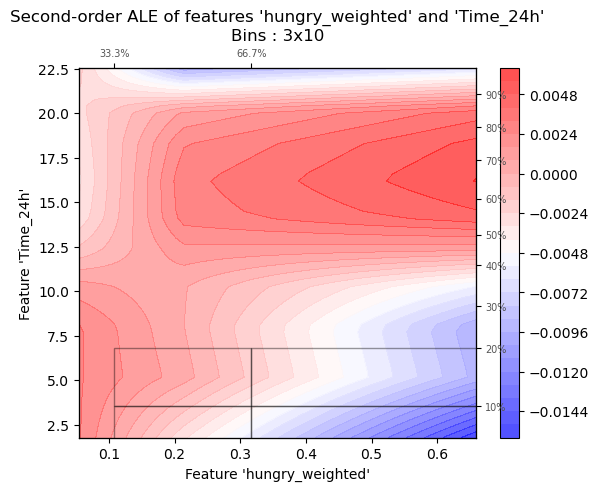

<Axes: title={'center': "Second-order ALE of features 'hungry_weighted' and 'Time_24h'\nBins : 3x10"}, xlabel="Feature 'hungry_weighted'", ylabel="Feature 'Time_24h'">

In [41]:
from alepython import ale_plot
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore", message="X has feature names, but RandomForestClassifier was fitted without feature names")

# DataFrame으로 변환
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# 1.5_2h_pre_std가 10 이하인 샘플만 필터링
# X_train_filtered = X_train_df[X_train_df["1.5_2h_pre_std"] <= 9]

# ALE Plot 그리기 (제한된 데이터로)
ale_plot(
    model=model,
    train_set=X_train_filtered,
    features=[ "hungry_weighted","Time_24h"],
    monte_carlo_rep=1000,
    bins=10,
)


# Validation w/holdout participants

In [81]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from datetime import timedelta

# 1. 홀드아웃 참가자 로드 및 전처리
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE"])

# 2. 예측
X_holdout = holdout_df[X_columns]
y_holdout = holdout_df["Onset_GE"].astype(int)
y_holdout_proba = model.predict_proba(X_holdout)[:, 1]
threshold = 0.2
y_holdout_pred = (y_holdout_proba >= threshold).astype(int)

# 3. 결과 merge
holdout_df["Predicted"] = y_holdout_pred
holdout_df["Predicted_Proba"] = y_holdout_proba

# 4. Timestamp 파싱
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])

# 5. 경고 탐지 함수 (60분 내 감지 + 2시간 쿨다운)
def detect_early_warning_with_cooldown(df, threshold=0.2, lead_minutes=60, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    ge_indices = df.index[df["Onset_GE"] == 1].tolist()
    early_detected = 0
    last_alert_time = None

    for ge_idx in ge_indices:
        ge_time = df.loc[ge_idx, "Timestamp"]
        window_start = ge_time - timedelta(minutes=lead_minutes)
        prior_window = df[(df["Timestamp"] >= window_start) & (df["Timestamp"] < ge_time)]

        # 쿨다운 조건 충족한 알림만 허용
        if not prior_window.empty:
            valid_alerts = prior_window[
                (prior_window["Predicted_Proba"] >= threshold) &
                (
                    last_alert_time is None or
                    (prior_window["Timestamp"] >= last_alert_time + timedelta(minutes=cooldown_minutes)).any()
                )
            ]
            if not valid_alerts.empty:
                early_detected += 1
                last_alert_time = valid_alerts["Timestamp"].min()

    return early_detected, len(ge_indices)

# 6. 참가자별 평가
results = []
for sid in holdout_df["StudyID"].unique():
    sub_df = holdout_df[holdout_df["StudyID"] == sid]
    detected, total = detect_early_warning_with_cooldown(
        sub_df, threshold=threshold, lead_minutes=60, cooldown_minutes=120
    )
    results.append({
        "StudyID": sid,
        "Detected_GE_Onset": detected,
        "Total_GE_Onset": total,
        "Detection_Rate": detected / total if total > 0 else np.nan
    })

# 7. 결과 요약
result_df = pd.DataFrame(results)
print("📊 Early Warning Detection Results (60 min window + 2hr cooldown):")
print(result_df)

# 8. 전체 통계
overall_detected = result_df["Detected_GE_Onset"].sum()
overall_total = result_df["Total_GE_Onset"].sum()
overall_rate = overall_detected / overall_total if overall_total > 0 else np.nan

print(f"\n✅ Overall Detection Rate (with cooldown): {overall_detected}/{overall_total} = {overall_rate:.4f}")


📊 Early Warning Detection Results (60 min window + 2hr cooldown):
   StudyID  Detected_GE_Onset  Total_GE_Onset  Detection_Rate
0        8                  6              18        0.333333
1       40                 14              30        0.466667
2       59                  8              12        0.666667
3       86                 10              27        0.370370

✅ Overall Detection Rate (with cooldown): 38/87 = 0.4368


📅 Participant 40 - Random GE Date: 2022-12-16


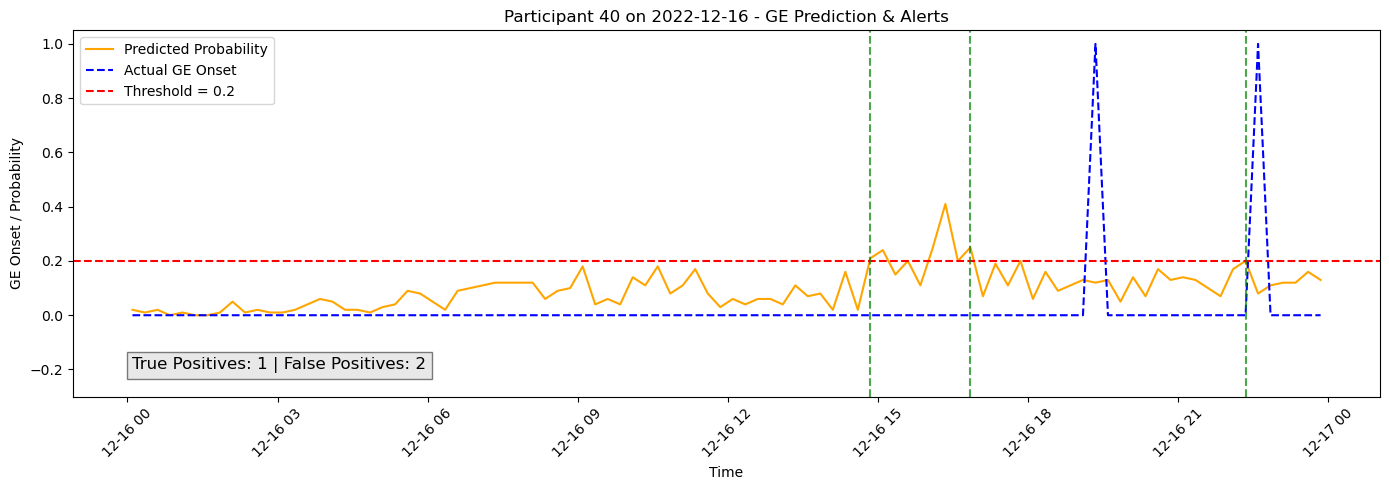

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import random

# 날짜 컬럼 추가
holdout_df["Date"] = holdout_df["Timestamp"].dt.date

# ✅ 랜덤한 날짜 선택 (GE가 1회 이상 발생한 날짜 중)
def get_random_ge_day(df, study_id):
    sub_df = df[df["StudyID"] == study_id]
    ge_dates = sub_df[sub_df["Onset_GE"] == 1]["Date"].unique()
    return np.random.choice(ge_dates)

# ✅ 쿨다운을 반영한 alert 시점 계산
def get_alert_times(df, threshold=0.2, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i, row in df.iterrows():
        if row["Predicted_Proba"] >= threshold and row["Timestamp"] >= last_alert_time + timedelta(minutes=cooldown_minutes):
            alert_times.append(row["Timestamp"])
            last_alert_time = row["Timestamp"]
    return alert_times

# ✅ TP / FP 계산 포함 시각화 함수
def plot_single_day_alerts_with_stats(df, study_id, date, threshold=0.2, cooldown_minutes=120, lead_minutes=60):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    ge_times = sub_df[sub_df["Onset_GE"] == 1]["Timestamp"].tolist()

    # TP 계산: 알림이 GE 발생 60분 이내에 포함될 경우
    tp_count = 0
    matched_alerts = set()

    for ge_time in ge_times:
        for alert_time in alert_times:
            if alert_time <= ge_time and alert_time >= ge_time - timedelta(minutes=lead_minutes):
                tp_count += 1
                matched_alerts.add(alert_time)
                break

    fp_count = len([t for t in alert_times if t not in matched_alerts])

    # 📊 시각화
    plt.figure(figsize=(14, 5))
    plt.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    plt.plot(sub_df["Timestamp"], sub_df["Onset_GE"], label="Actual GE Onset", linestyle="--", color="blue")
    plt.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")

    for alert_time in alert_times:
        plt.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)

    # 통계 텍스트
    stats_text = f"True Positives: {tp_count} | False Positives: {fp_count}"
    plt.text(
        sub_df["Timestamp"].iloc[0],
        -0.2,
        stats_text,
        fontsize=12,
        bbox=dict(facecolor='lightgray', alpha=0.5)
    )

    plt.title(f"Participant {study_id} on {date} - GE Prediction & Alerts")
    plt.xlabel("Time")
    plt.ylabel("GE Onset / Probability")
    plt.xticks(rotation=45)
    plt.ylim(-0.3, 1.05)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ✅ 예시: 랜덤 날짜 추출 → 시각화 실행
participant_id = 40
random_date = get_random_ge_day(holdout_df, participant_id)
print(f"📅 Participant {participant_id} - Random GE Date: {random_date}")

plot_single_day_alerts_with_stats(
    df=holdout_df,
    study_id=participant_id,
    date=random_date,
    threshold=0.2,
    cooldown_minutes=120,
    lead_minutes=60
)


📅 Participant 8 - Random GE Date: 2022-10-29


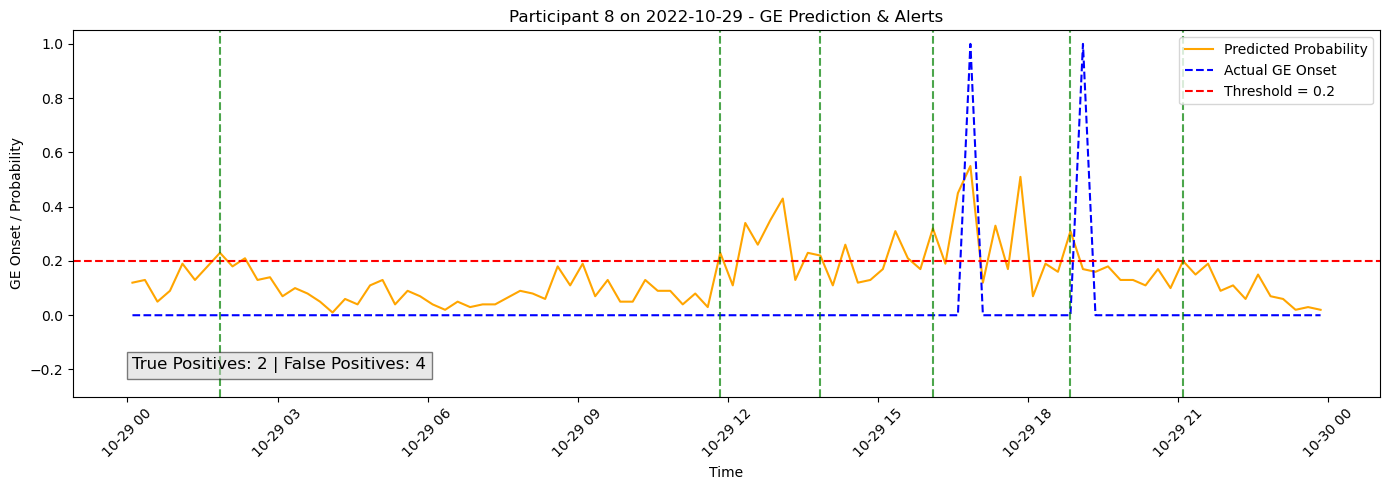

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import random

# 날짜 컬럼 추가
holdout_df["Date"] = holdout_df["Timestamp"].dt.date

# ✅ 랜덤한 날짜 선택 (GE가 1회 이상 발생한 날짜 중)
def get_random_ge_day(df, study_id):
    sub_df = df[df["StudyID"] == study_id]
    ge_dates = sub_df[sub_df["Onset_GE"] == 1]["Date"].unique()
    return np.random.choice(ge_dates)

# ✅ 쿨다운을 반영한 alert 시점 계산
def get_alert_times(df, threshold=0.2, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i, row in df.iterrows():
        if row["Predicted_Proba"] >= threshold and row["Timestamp"] >= last_alert_time + timedelta(minutes=cooldown_minutes):
            alert_times.append(row["Timestamp"])
            last_alert_time = row["Timestamp"]
    return alert_times

# ✅ TP / FP 계산 포함 시각화 함수
def plot_single_day_alerts_with_stats(df, study_id, date, threshold=0.2, cooldown_minutes=120, lead_minutes=60):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    ge_times = sub_df[sub_df["Onset_GE"] == 1]["Timestamp"].tolist()

    # TP 계산: 알림이 GE 발생 60분 이내에 포함될 경우
    tp_count = 0
    matched_alerts = set()

    for ge_time in ge_times:
        for alert_time in alert_times:
            if alert_time <= ge_time and alert_time >= ge_time - timedelta(minutes=lead_minutes):
                tp_count += 1
                matched_alerts.add(alert_time)
                break

    fp_count = len([t for t in alert_times if t not in matched_alerts])

    # 📊 시각화
    plt.figure(figsize=(14, 5))
    plt.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    plt.plot(sub_df["Timestamp"], sub_df["Onset_GE"], label="Actual GE Onset", linestyle="--", color="blue")
    plt.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")

    for alert_time in alert_times:
        plt.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)

    # 통계 텍스트
    stats_text = f"True Positives: {tp_count} | False Positives: {fp_count}"
    plt.text(
        sub_df["Timestamp"].iloc[0],
        -0.2,
        stats_text,
        fontsize=12,
        bbox=dict(facecolor='lightgray', alpha=0.5)
    )

    plt.title(f"Participant {study_id} on {date} - GE Prediction & Alerts")
    plt.xlabel("Time")
    plt.ylabel("GE Onset / Probability")
    plt.xticks(rotation=45)
    plt.ylim(-0.3, 1.05)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ✅ 예시: 랜덤 날짜 추출 → 시각화 실행
participant_id = 8
random_date = get_random_ge_day(holdout_df, participant_id)
print(f"📅 Participant {participant_id} - Random GE Date: {random_date}")

plot_single_day_alerts_with_stats(
    df=holdout_df,
    study_id=participant_id,
    date=random_date,
    threshold=0.2,
    cooldown_minutes=120,
    lead_minutes=60
)

In [177]:
from sklearn.metrics import precision_score, recall_score, f1_score

summary = []

for sid in holdout_df["StudyID"].unique():
    df_sub = holdout_df[holdout_df["StudyID"] == sid].copy()
    
    df_sub["Onset_GE"] = df_sub["Onset_GE"].astype(int)
    df_sub["Predicted"] = df_sub["Predicted"].astype(int)
    
    total = len(df_sub)
    actual_ge = df_sub["Onset_GE"].sum()
    predicted_ge = df_sub["Predicted"].sum()

    tp = ((df_sub["Onset_GE"] == 1) & (df_sub["Predicted"] == 1)).sum()
    fp = ((df_sub["Onset_GE"] == 0) & (df_sub["Predicted"] == 1)).sum()
    fn = ((df_sub["Onset_GE"] == 1) & (df_sub["Predicted"] == 0)).sum()

    precision = precision_score(df_sub["Onset_GE"], df_sub["Predicted"], zero_division=0)
    recall = recall_score(df_sub["Onset_GE"], df_sub["Predicted"], zero_division=0)
    f1 = f1_score(df_sub["Onset_GE"], df_sub["Predicted"], zero_division=0)

    summary.append({
        "StudyID": sid,
        "Total": total,
        "GE Count": actual_ge,
        "Predicted GE": predicted_ge,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4)
    })

# DataFrame 생성
performance_df = pd.DataFrame(summary)

# 전체 요약 행 추가
total_tp = performance_df["TP"].sum()
total_fp = performance_df["FP"].sum()
total_fn = performance_df["FN"].sum()
total_actual = performance_df["GE Count"].sum()
total_pred = performance_df["Predicted GE"].sum()
total_records = performance_df["Total"].sum()

total_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
total_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
total_f1 = 2 * total_precision * total_recall / (total_precision + total_recall) if (total_precision + total_recall) > 0 else 0

performance_df.loc[len(performance_df.index)] = {
    "StudyID": "Total",
    "Total": total_records,
    "GE Count": total_actual,
    "Predicted GE": total_pred,
    "TP": total_tp,
    "FP": total_fp,
    "FN": total_fn,
    "Precision": round(total_precision, 4),
    "Recall": round(total_recall, 4),
    "F1 Score": round(total_f1, 4)
}

# 출력
print("📊 Holdout Participant-wise Performance Summary (including Total):")
print(performance_df)


📊 Holdout Participant-wise Performance Summary (including Total):
  StudyID  Total  GE Count  Predicted GE  TP   FP  FN  Precision  Recall  \
0       8    822        18           149   7  142  11     0.0470  0.3889   
1      40    823        30           125   7  118  23     0.0560  0.2333   
2      59    848        12           166   3  163   9     0.0181  0.2500   
3      86    791        27            85   5   80  22     0.0588  0.1852   
4   Total   3284        87           525  22  503  65     0.0419  0.2529   

   F1 Score  
0    0.0838  
1    0.0903  
2    0.0337  
3    0.0893  
4    0.0719  
